In [1]:
import pandas as pd
import sys

sys.path.append("../..")
from digitalhistopathology.embeddings.image_embedding import ImageEmbedding

import anndata as ad
from umap import UMAP

2025-11-25 11:15:43.591013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-11-25 11:15:43.591130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-11-25 11:15:43.591138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
optimal_HER2_model = "uni_full_koleo_16384_prototypes"
min_dist = 0.001
n_neighbors = 250
n_clusters = 5

In [3]:
## recompute UMAP with these parameters

invasive_HER2_embedding_path = "../../results/HER2/pipeline/HER2_uni_full_koleo_16384_prototypes/invasive_image_embedding.h5ad"
emb = ad.read_h5ad(invasive_HER2_embedding_path)    

In [4]:
        
HER2_emb = ImageEmbedding(        
        pretrained_model=None,
        emb=emb,
        result_saving_folder="results",
        name="HER2",
    )

In [5]:
umap_reducer = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric="euclidean", random_state=42)
umap_reducer.fit(HER2_emb.emb.X)



/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.001, n_neighbors=250, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [6]:
HER2_emb.emb.obsm["umap"] = umap_reducer.transform(HER2_emb.emb.X)[:, 0:2]

In [7]:
invasive_TNBC_embedding_path = "../../results/TNBC/pipeline/HER2_uni_full_koleo_16384_prototypes/invasive_image_embedding.h5ad"
emb = ad.read_h5ad(invasive_TNBC_embedding_path)    

TNBC_emb = ImageEmbedding(        
        pretrained_model=None,
        emb=emb,
        result_saving_folder="results",
        name="TNBC",
    )

In [ ]:
# This cell takes 9min
TNBC_emb.emb.obsm["umap"] = umap_reducer.transform(TNBC_emb.emb.X)[:, 0:2]

In [9]:
HER2_emb.emb.write_h5ad("../../results/transferability_exp/HER2_uni_full_koleo_16384_prototypes_space.h5ad")
TNBC_emb.emb.write_h5ad("../../results/transferability_exp/TNBC_dataset_projected_in_HER2_uni_full_koleo_16384_prototypes_space.h5ad")

In [10]:
# Let's add labels
labels_her2 = pd.read_csv("../../results/HER2/benchmark/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_16384_prototypes/invasive_labels_5_clusters_umap_min_dist_0.001_n_neighbors_250.csv",
                          index_col=0)

In [ ]:
HER2_emb.emb.obs.drop(["predicted_label"], axis=1, inplace=True)

In [18]:
HER2_emb.emb.obs = HER2_emb.emb.obs.merge(labels_her2[['predicted_label']], left_index=True, right_index=True)

/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


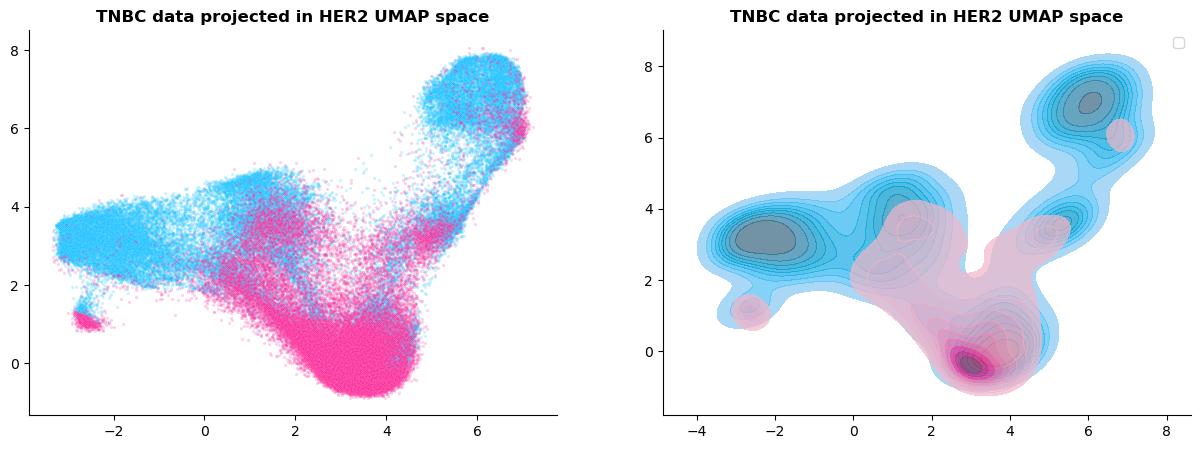

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=HER2_emb.emb.obsm["umap"][:, 0],
                y=HER2_emb.emb.obsm["umap"][:, 1],
                color="deepskyblue", s=5, alpha=0.2)

sns.scatterplot(x=TNBC_emb.emb.obsm["umap"][:, 0],
                y=TNBC_emb.emb.obsm["umap"][:, 1],
                color="deeppink", s=5, alpha=0.2)

plt.title("TNBC data projected in HER2 UMAP space", weight='bold')
sns.despine()

plt.subplot(1, 2, 2)
sns.kdeplot(x=HER2_emb.emb.obsm["umap"][:, 0],
                y=HER2_emb.emb.obsm["umap"][:, 1],
                color="deepskyblue", s=5, alpha=0.7, fill=True, label="HER2")

sns.kdeplot(x=TNBC_emb.emb.obsm["umap"][:, 0],
                y=TNBC_emb.emb.obsm["umap"][:, 1],
                color="deeppink", s=5, fill=True, alpha=0.7, label="TNBC")

plt.title("TNBC data projected in HER2 UMAP space", weight='bold')
plt.legend()
sns.despine()


# Perform knn classification from HER2 to TNBC UMAP embeddings

In [21]:
X_train = HER2_emb.emb.obsm["umap"]
Y_train = HER2_emb.emb.obs["predicted_label"]

X_test = TNBC_emb.emb.obsm["umap"]

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, Y_train)
predicted_labels_TNBC = knn.predict(X_test)

In [54]:
palette={0: '#F9A11B', 
         1: '#31C4F3',
         2: '#ACB5B6', 
         3: '#EC2A90', 
         4: '#66BB46', 
         }
         

<Axes: title={'center': 'TNBC predicted labels distribution \n (from HER2 UMAP space)'}>

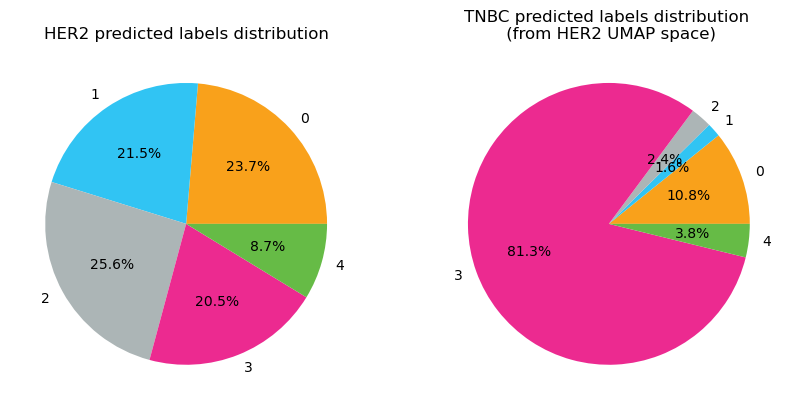

In [55]:
# Pie charts to represent labels in HER2 and TNBC datasets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
HER2_emb.emb.obs["predicted_label"].value_counts().sort_index().plot.pie(autopct='%1.1f%%', colors=palette.values(),
                                                                        title="HER2 predicted labels distribution",
                                                                        ylabel="")

plt.subplot(1, 2, 2)
pd.Series(predicted_labels_TNBC).value_counts().sort_index().plot.pie(autopct='%1.1f%%', colors=palette.values(),
                                                                        title=f"TNBC predicted labels distribution \n (from HER2 UMAP space)",
                                                                        ylabel="")  

In [27]:
TNBC_emb.emb.obs["predicted_label_from_HER2_space"] = predicted_labels_TNBC

In [37]:
label = TNBC_emb.emb.obs[["predicted_label_from_HER2_space"]].rename(columns={"predicted_label_from_HER2_space": "predicted_label"})

In [38]:
label["label"] = ""

In [ ]:
label.to_csv("../../results/transferability_exp/TNBC_predicted_labels_from_HER2_space.csv")

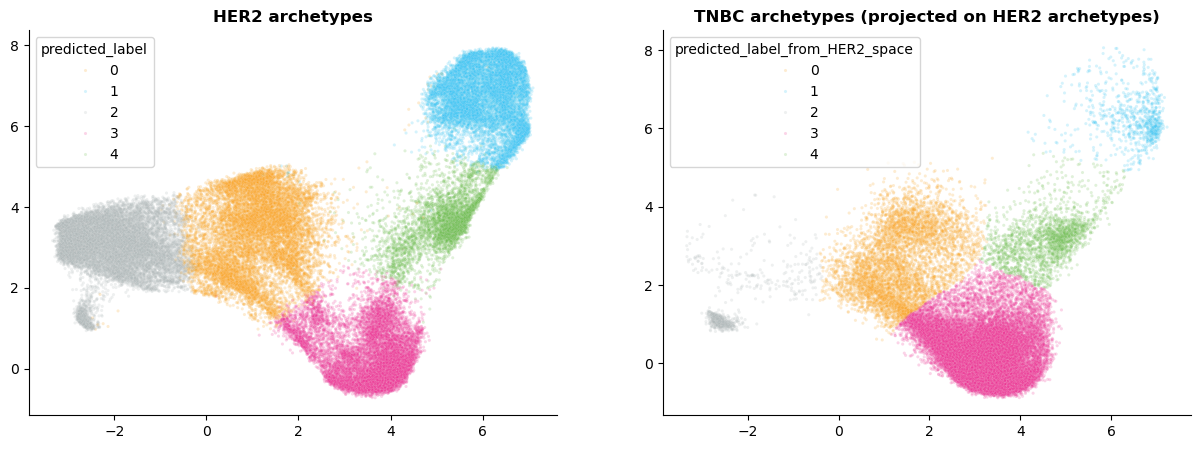

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=HER2_emb.emb.obsm["umap"][:, 0],
                y=HER2_emb.emb.obsm["umap"][:, 1],
                hue=HER2_emb.emb.obs["predicted_label"], s=5, alpha=0.2,
                palette=palette)

plt.title("HER2 archetypes", weight='bold')
sns.despine()

plt.subplot(1, 2, 2)
sns.scatterplot(x=TNBC_emb.emb.obsm["umap"][:, 0],
                y=TNBC_emb.emb.obsm["umap"][:, 1],
                hue=TNBC_emb.emb.obs["predicted_label_from_HER2_space"], s=5, alpha=0.2,
                palette=palette)
plt.title("TNBC archetypes (projected on HER2 archetypes)", weight='bold')
sns.despine()